생각보다 오버피팅이 잘 일어나는 듯 조심해야함!

# Data Set

In [65]:
import warnings
warnings.filterwarnings('ignore')

import koreanize_matplotlib

In [1]:
import pandas as pd

train = pd.read_csv('Data/train_0820.csv')
test = pd.read_csv('Data/test_0820.csv')

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_date_time       16800 non-null  object 
 1   건물번호                16800 non-null  int64  
 2   일시                  16800 non-null  object 
 3   기온(°C)              16800 non-null  float64
 4   강수량(mm)             16800 non-null  float64
 5   풍속(m/s)             16800 non-null  float64
 6   습도(%)               16800 non-null  float64
 7   건물유형                16800 non-null  object 
 8   연면적(m2)             16800 non-null  float64
 9   냉방면적(m2)            16800 non-null  float64
 10  태양광용량(kW)           16800 non-null  float64
 11  ESS저장용량(kWh)        16800 non-null  float64
 12  PCS용량(kW)           16800 non-null  float64
 13  month               16800 non-null  int64  
 14  day                 16800 non-null  int64  
 15  hour                16800 non-null  int64  
 16  week

In [2]:
submit =  pd.read_csv('Data/sample_submission.csv')
submit

,num_date_time,answer
0,1_20240825 00,0
1,1_20240825 01,0
2,1_20240825 02,0
3,1_20240825 03,0
4,1_20240825 04,0
...,...,...
16795,100_20240831 19,0
16796,100_20240831 20,0
16797,100_20240831 21,0
16798,100_20240831 22,0


In [5]:
import random
import numpy as np
import os
from xgboost import XGBRegressor

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [41]:
train['건물유형'] = train['건물유형'].astype('category')
train_x = train.drop(['num_date_time', '일시', '일사(MJ/m2)', '일조(hr)', '전력소비량(kWh)'],axis = 1).iloc[:,:-10]
train_y = train['전력소비량(kWh)']

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [43]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((163200, 36), (40800, 36), (163200,), (40800,))

In [15]:
import numpy as np

def smape(y_true, y_pred):
    """
    SMAPE (Symmetric Mean Absolute Percentage Error)
    y_true: 실제값 (array-like)
    y_pred: 예측값 (array-like)
    반환값: SMAPE (단위: %)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_pred - y_true)
    # 0으로 나누는 경우는 diff=0 이므로 0으로 처리됨
    smape_val = 100 * np.mean(2 * diff / np.where(denominator == 0, 1, denominator))
    return smape_val


## baseline 모델 적용 - 건물유형을 더미화하여 학습 -- 8.951%

In [44]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=800, 
    max_splits= 512,
    random_state=42,
    enable_categorical=True  
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:2738.34592	validation_1-rmse:2723.59005
[1]	validation_0-rmse:2092.82946	validation_1-rmse:2082.15012
[2]	validation_0-rmse:1631.70692	validation_1-rmse:1627.94322
[3]	validation_0-rmse:1334.32858	validation_1-rmse:1332.80904
[4]	validation_0-rmse:1125.33929	validation_1-rmse:1124.40561
[5]	validation_0-rmse:997.45804	validation_1-rmse:997.48060
[6]	validation_0-rmse:906.41169	validation_1-rmse:905.83699
[7]	validation_0-rmse:831.71302	validation_1-rmse:829.99474
[8]	validation_0-rmse:764.54988	validation_1-rmse:763.26134
[9]	validation_0-rmse:711.97717	validation_1-rmse:711.57513
[10]	validation_0-rmse:681.71383	validation_1-rmse:681.71469
[11]	validation_0-rmse:645.15917	validation_1-rmse:644.34299
[12]	validation_0-rmse:609.10877	validation_1-rmse:609.16498
[13]	validation_0-rmse:584.21505	validation_1-rmse:583.76718
[14]	validation_0-rmse:553.10968	validation_1-rmse:553.16211
[15]	validation_0-rmse:535.27783	validation_1-rmse:535.20689
[16]	validation_0-rmse:5

/opt/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_splits" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[24]	validation_0-rmse:426.52836	validation_1-rmse:428.42496
[25]	validation_0-rmse:421.76916	validation_1-rmse:423.76274
[26]	validation_0-rmse:417.87267	validation_1-rmse:419.66925
[27]	validation_0-rmse:413.02675	validation_1-rmse:415.48536
[28]	validation_0-rmse:409.86436	validation_1-rmse:412.70867
[29]	validation_0-rmse:406.07852	validation_1-rmse:408.81086
[30]	validation_0-rmse:400.14968	validation_1-rmse:404.01266
[31]	validation_0-rmse:394.69197	validation_1-rmse:399.28880
[32]	validation_0-rmse:392.13916	validation_1-rmse:397.17356
[33]	validation_0-rmse:389.21014	validation_1-rmse:394.22245
[34]	validation_0-rmse:386.48381	validation_1-rmse:391.57155
[35]	validation_0-rmse:382.93963	validation_1-rmse:388.44935
[36]	validation_0-rmse:379.98493	validation_1-rmse:386.01149
[37]	validation_0-rmse:378.31151	validation_1-rmse:384.67850
[38]	validation_0-rmse:375.96561	validation_1-rmse:382.61418
[39]	validation_0-rmse:373.96087	validation_1-rmse:380.87152
[40]	validation_0-rmse:3

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [45]:
# 예측
val_pred = model.predict(X_val)
print(f'SMAPE: {smape(y_val, val_pred):.3f} %')

SMAPE: 8.913 %


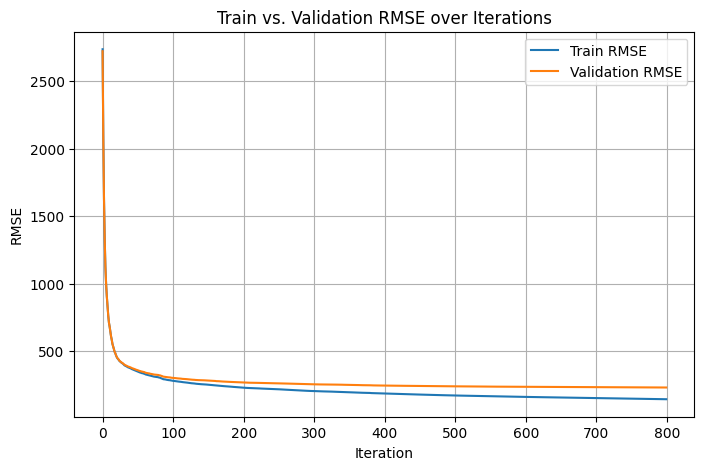

In [46]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse'] 

plt.figure(figsize=(8,5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Train vs. Validation RMSE over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
test['건물유형'] = test['건물유형'].astype('category')
test_x = test[train_x.columns]

pred =  model.predict(test_x)
submit['answer'] = pred
submit.to_csv(f'Submit/submit0820_cate{smape(y_val, val_pred):.3f}.csv',index = False)

## 각 건물유형별로 따로 모델을 만들어 결과를 병합

In [82]:
from sklearn.metrics import make_scorer

# SMAPE 기반 scorer
def smape_scorer(y_true, y_pred):
    return -smape(y_true, y_pred)  # 음수화 → 최소화 문제를 최대화로 바꿈

scorer = make_scorer(smape_scorer, greater_is_better=True)

# 탐색할 파라미터 후보
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

building_types = train['건물유형'].unique()
val_scores = {}
models = {}
preds_list = []

In [83]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

building_types = train['건물유형'].unique()
val_scores = {}
models = {}
preds_list = []

for btype in building_types:
    # 1. 해당 건물유형 train/test 데이터 선택
    train_sub = train[train['건물유형'] == btype]
    test_sub  = test[test['건물유형'] == btype]

    # 2. feature, target 분리
    drop_cols = ['num_date_time', '일시', '건물유형', '일사(MJ/m2)', '일조(hr)', '전력소비량(kWh)']
    X = train_sub.drop(columns=drop_cols)
    y = train_sub['전력소비량(kWh)']

    # 3. train/val 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    4. 모델 정의 (eval_metric은 여기!)
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",   # GPU → "gpu_hist"
        random_state=42,
        n_jobs=-1,
        eval_metric="mae"     # ✅ fit이 아니라 여기서 지정
    )

    # 5. 모델 학습
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    

    # 6. Validation 성능 저장
    y_val_pred = model.predict(X_val)
    val_scores[btype] = smape(y_val, y_val_pred)

    # 7. 모델 저장
    models[btype] = model

    # 8. test 데이터 예측
    X_test = test_sub.drop(columns=['num_date_time', '일시', '건물유형'])
    test_sub['pred'] = model.predict(X_test)

    preds_list.append(test_sub[['num_date_time', '건물번호', 'pred']])

# 전체 예측 결과 합치기
final_preds = pd.concat(preds_list).sort_values(by=['num_date_time', '건물번호'])


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [80]:
# 건물유형별 성능 출력
for btype, score in val_scores.items():
    print(f"{btype}: {score:.4f}")

# 단순 평균
avg_smape = sum(val_scores.values()) / len(val_scores)
print("평균 SMAPE:", avg_smape)

# 데이터 개수 가중 평균 (유형별 샘플 수 반영)
weighted_smape = 0
total_samples = 0
for btype in building_types:
    n = len(train[train['건물유형'] == btype])
    weighted_smape += val_scores[btype] * n
    total_samples += n
weighted_smape /= total_samples
print("가중 평균 SMAPE:", weighted_smape)

호텔: 6.7349
상용: 3.1209
병원: 3.3012
학교: 3.9484
건물기타: 6.5414
아파트: 12.5144
연구소: 5.6437
백화점: 7.7544
IDC(전화국): 1.2896
공공: 6.0315
평균 SMAPE: 5.688046467741318
가중 평균 SMAPE: 5.805190846908635


====> 점수 8.16

In [79]:
submit_final = (
    submit
    .merge(final_preds, on=['num_date_time'], how='left')
    .drop(columns=['answer','건물번호'], axis = 1)                          # 기존 answer 버리고
    .rename(columns={'pred': 'answer'})                # pred → answer 로 변경
)
submit_final.to_csv(f'Submit/submit0820_건물별.csv',index = False)

In [85]:
val_scores = {}
models = {}
preds_list = []

for btype in building_types:
    # 1. 해당 건물유형 train/test 데이터 선택
    train_sub = train[train['건물유형'] == btype]
    test_sub  = test[test['건물유형'] == btype]

    # 2. feature, target 분리
    drop_cols = ['num_date_time', '일시', '건물유형', '일사(MJ/m2)', '일조(hr)', '전력소비량(kWh)']
    X = train_sub.drop(columns=drop_cols)
    y = train_sub['전력소비량(kWh)']

    # 3. train/val 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 4. 기본 모델
    xgb_model = xgb.XGBRegressor(
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        eval_metric="mae"
    )

    # 5. RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=20,      # 랜덤 20세트 탐색
        scoring=scorer,
        cv=3,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    # 최적 모델 추출
    best_model = random_search.best_estimator_

    # 6. Validation 성능 저장
    y_val_pred = best_model.predict(X_val)
    val_scores[btype] = smape(y_val, y_val_pred)

    # 7. 모델 저장
    models[btype] = best_model

    # 8. test 데이터 예측
    X_test = test_sub.drop(columns=['num_date_time', '일시', '건물유형'])
    test_sub['pred'] = best_model.predict(X_test)

    preds_list.append(test_sub[['num_date_time', '건물번호', 'pred']])

# 전체 예측 결과 합치기
final_preds = pd.concat(preds_list).sort_values(by=['num_date_time', '건물번호'])

# 건물유형별 성능 확인
print("건물유형별 SMAPE:", val_scores)
print("평균 SMAPE:", sum(val_scores.values())/len(val_scores))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
건물유형별 SMAPE: {'호텔': np.float64(5.478829329631578), '상용': np.float64(2.37127242688739), '병원': np.float64(2.8690118440377113), '학교': np.float64(3.1780931248729836), '건물기타': np.float64(4.864568976094049), '아파트': np.float64(5.4115226483923475), '연구소': np.float64(4.063476123687812), '백화점': np.float64(5.220551669880712), 'IDC(전화국)': np.float64(0.8846606321994654), '공공': np.float64(4.7840297586

In [87]:
submit_final = (
    submit
    .merge(final_preds, on=['num_date_time'], how='left')
    .drop(columns=['answer','건물번호'], axis = 1)                          # 기존 answer 버리고
    .rename(columns={'pred': 'answer'})                # pred → answer 로 변경
)
submit_final.to_csv(f'Submit/submit0820_건물별그리드서치.csv',index = False)
submit_final

,num_date_time,answer
0,1_20240825 00,4893.158203
1,1_20240825 01,4297.770996
2,1_20240825 02,3798.028320
3,1_20240825 03,3412.207764
4,1_20240825 04,3029.912598
...,...,...
16795,100_20240831 19,2983.988525
16796,100_20240831 20,2773.358643
16797,100_20240831 21,2636.339600
16798,100_20240831 22,2602.651123


=====> 점수 7.62 # 현재에서 가장 좋은 결과 도출

In [88]:
best_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=-1, num_parallel_tree=None, ...)>

### 현재 베스트 모델 기준으로 피쳐임포턴스 확인


=== 건물유형: 호텔 ===
               feature    importance
5              연면적(m2)  9.998058e+07
6             냉방면적(m2)  5.067894e+07
23           month_cos  4.373246e+07
22           month_sin  2.648034e+07
8                month  2.212490e+07
0                 건물번호  1.290325e+07
14       cdh_base_used  3.182670e+06
30  cooling_load_index  1.845929e+06
21            hour_cos  1.330619e+06
10                hour  1.312741e+06


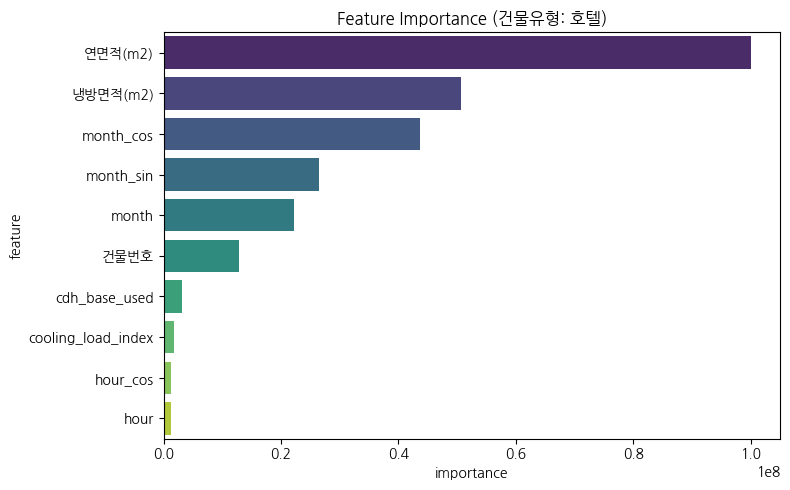


=== 건물유형: 상용 ===
               feature    importance
5              연면적(m2)  3.450769e+07
14       cdh_base_used  1.841147e+07
18     cool_area_ratio  5.210358e+06
6             냉방면적(m2)  3.220923e+06
30  cooling_load_index  2.383698e+06
12          is_weekend  2.278324e+06
21            hour_cos  1.499691e+06
13             holiday  1.075678e+06
11             weekday  8.192004e+05
10                hour  5.739552e+05


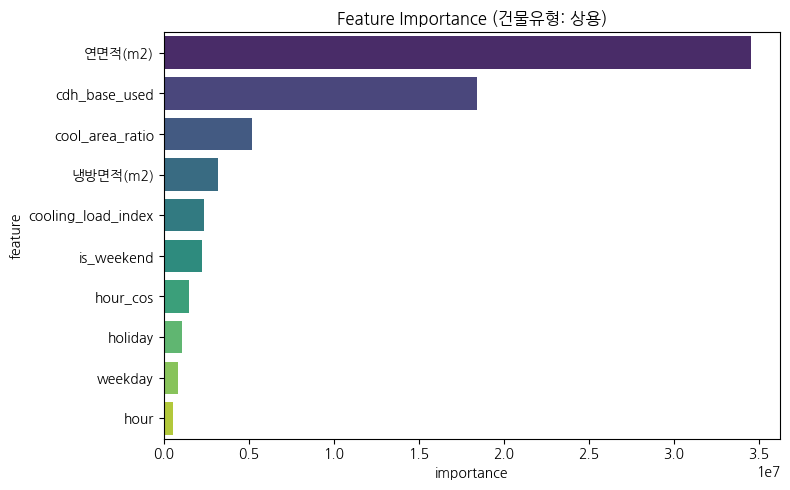


=== 건물유형: 병원 ===
       feature    importance
0         건물번호  1.638476e+08
5      연면적(m2)  1.462343e+08
6     냉방면적(m2)  2.748383e+07
24    hour_cos  1.735653e+07
14  is_weekend  1.429364e+07
26   month_cos  7.746048e+06
7    태양광용량(kW)  6.394376e+06
13     weekday  5.017462e+06
25   month_sin  4.758191e+06
15     holiday  3.756802e+06


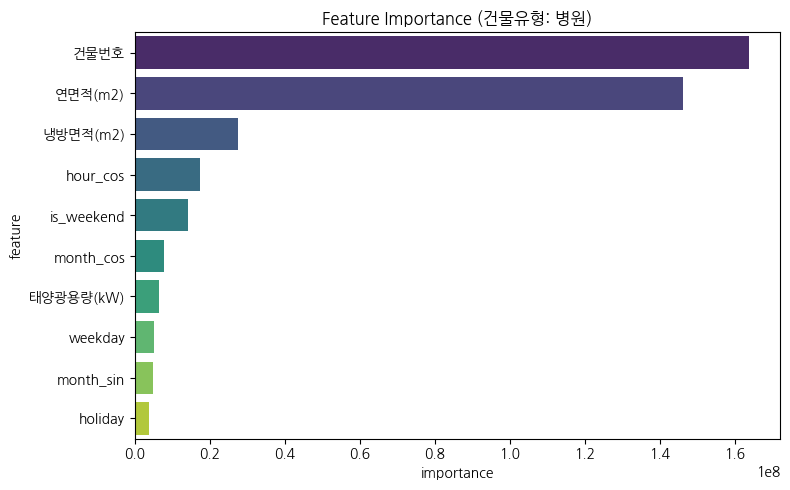


=== 건물유형: 학교 ===
         feature    importance
7      태양광용량(kW)  2.537660e+08
8   ESS저장용량(kWh)  1.019012e+08
6       냉방면적(m2)  3.965930e+07
5        연면적(m2)  2.677279e+07
0           건물번호  1.012704e+07
9      PCS용량(kW)  5.112316e+06
14    is_weekend  4.028728e+06
12          hour  2.683985e+06
15       holiday  1.583838e+06
13       weekday  1.573285e+06


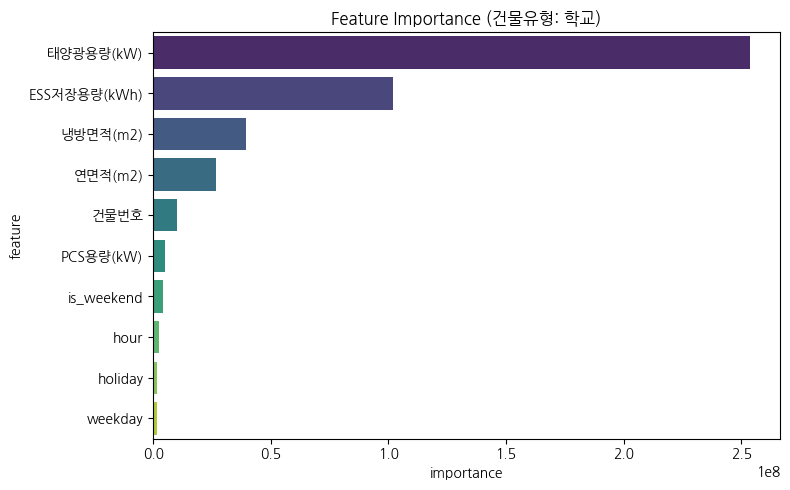


=== 건물유형: 건물기타 ===
          feature    importance
8    ESS저장용량(kWh)  1.325867e+09
7       태양광용량(kW)  3.264990e+08
9       PCS용량(kW)  4.534137e+07
25      month_cos  1.190258e+07
16  cdh_base_used  6.588716e+06
10          month  6.455210e+06
24      month_sin  5.849966e+06
0            건물번호  5.270516e+06
12           hour  1.904687e+06
14     is_weekend  1.385824e+06


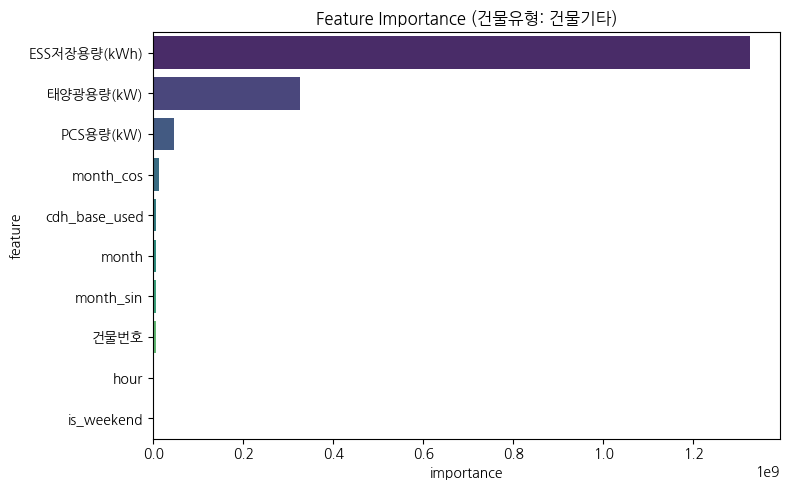


=== 건물유형: 아파트 ===
               feature    importance
13       cdh_base_used  1.332405e+07
5              연면적(m2)  4.201154e+06
6             냉방면적(m2)  1.253577e+06
22           month_cos  6.185325e+05
14                  DI  5.898038e+05
9                 hour  4.203733e+05
29  cooling_load_index  3.996908e+05
7                month  3.637088e+05
15                 THI  3.119377e+05
21           month_sin  2.744131e+05


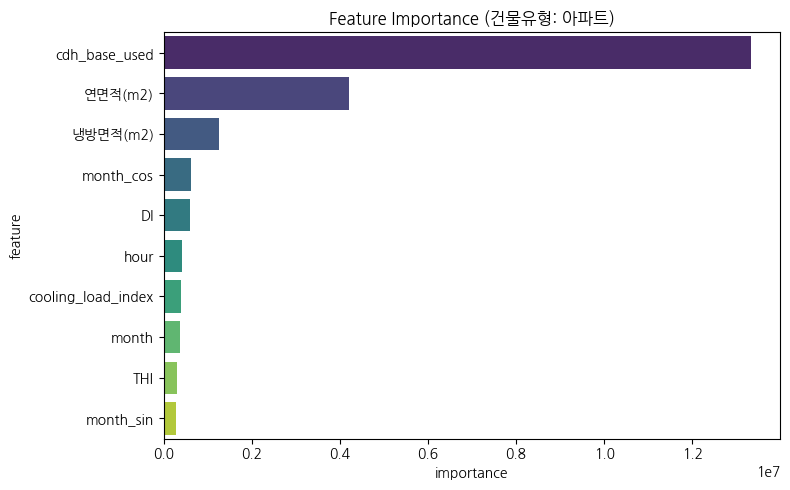


=== 건물유형: 연구소 ===
            feature    importance
5           연면적(m2)  7.089559e+06
20  cool_area_ratio  5.517676e+06
14       is_weekend  4.136070e+06
15          holiday  2.452941e+06
6          냉방면적(m2)  1.745254e+06
24         hour_cos  1.725930e+06
22     is_peak_hour  1.461824e+06
13          weekday  1.336014e+06
26        month_cos  1.190201e+06
0              건물번호  9.964561e+05


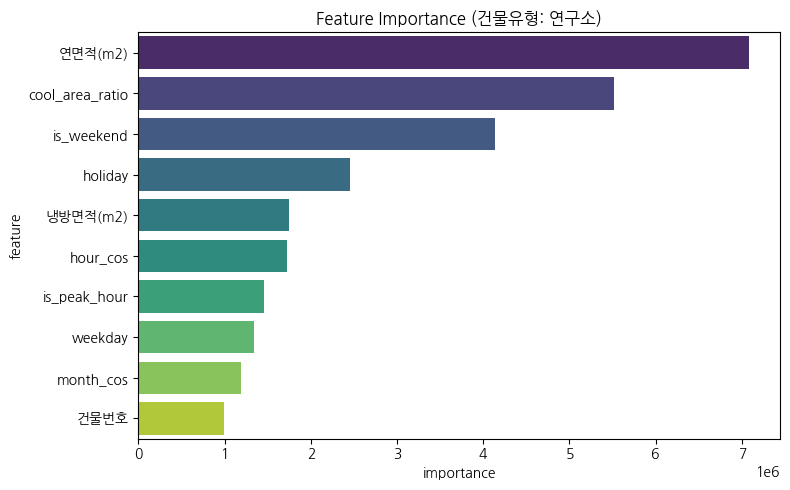


=== 건물유형: 백화점 ===
               feature    importance
5              연면적(m2)  1.052697e+08
9            PCS용량(kW)  6.013614e+07
8         ESS저장용량(kWh)  5.100278e+07
6             냉방면적(m2)  4.663660e+07
12                hour  3.527883e+07
0                 건물번호  1.086003e+07
23            hour_cos  5.390220e+06
32  cooling_load_index  4.775154e+06
22            hour_sin  3.922206e+06
25           month_cos  2.777056e+06


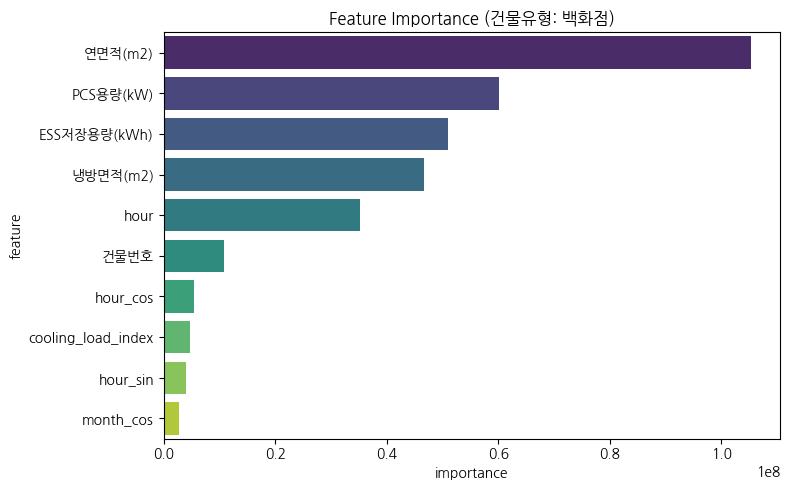


=== 건물유형: IDC(전화국) ===
            feature    importance
6          냉방면적(m2)  1.907322e+08
18  cool_area_ratio  1.634784e+08
0              건물번호  1.347064e+08
5           연면적(m2)  7.876229e+07
7         태양광용량(kW)  1.208420e+07
23        month_cos  7.594300e+06
22        month_sin  2.147154e+06
8             month  2.128872e+06
10             hour  1.322106e+06
9               day  5.309689e+05


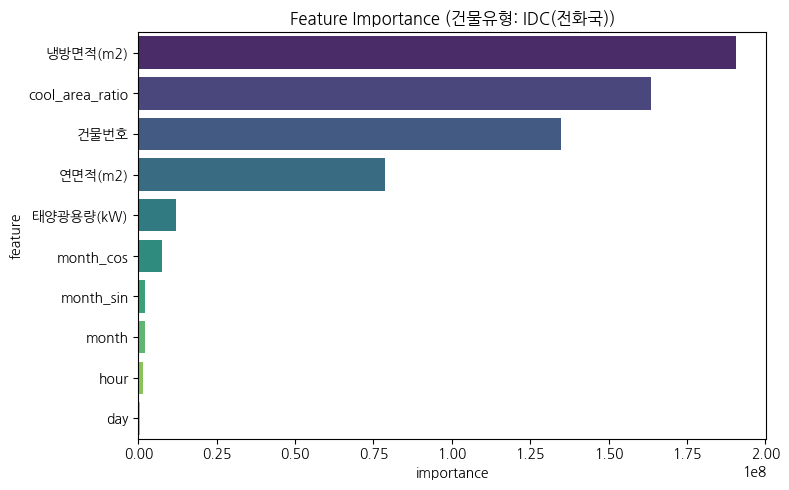


=== 건물유형: 공공 ===
       feature    importance
5      연면적(m2)  5.325980e+06
14  is_weekend  1.958955e+06
6     냉방면적(m2)  1.781899e+06
26   month_cos  1.680878e+06
25   month_sin  1.154188e+06
24    hour_cos  1.126694e+06
15     holiday  6.688365e+05
0         건물번호  5.869896e+05
10       month  5.589170e+05
13     weekday  5.144900e+05


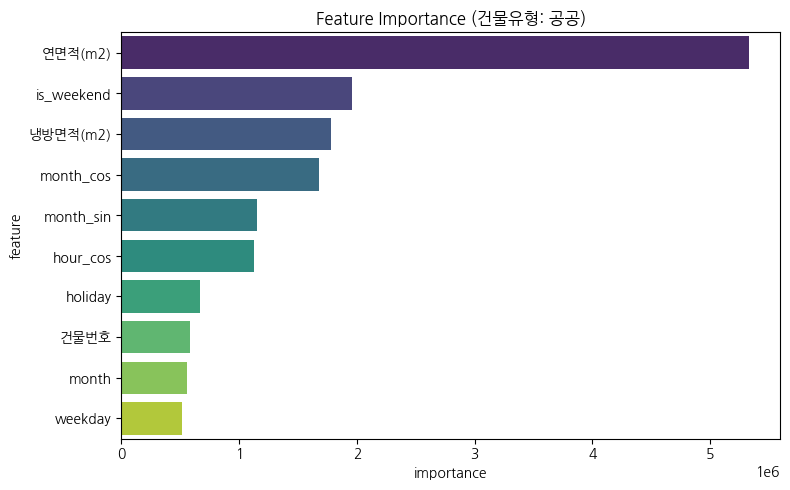

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

for btype, model in models.items():
    # feature importance 추출 (gain 기준)
    importance = model.get_booster().get_score(importance_type='gain')
    
    # dict → DataFrame 변환
    fi = pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    }).sort_values(by='importance', ascending=False)
    
    print(f"\n=== 건물유형: {btype} ===")
    print(fi.head(10))  # 상위 10개 feature 출력
    
    # 시각화
    plt.figure(figsize=(8,5))
    sns.barplot(data=fi.head(10), x='importance', y='feature', palette='viridis')
    plt.title(f"Feature Importance (건물유형: {btype})")
    plt.tight_layout()
    plt.show()


In [90]:
import pandas as pd

# 가중 중요도 집계용 딕셔너리
all_importances = {}

for btype, model in models.items():
    # 건물유형별 feature importance (gain 기준)
    importance = model.get_booster().get_score(importance_type='gain')
    
    # 가중치 = 해당 건물유형 샘플 수
    weight = len(train[train['건물유형']==btype])
    
    for feat, val in importance.items():
        if feat not in all_importances:
            all_importances[feat] = 0
        all_importances[feat] += val * weight   # 가중합

# DataFrame 변환
fi_all = pd.DataFrame(list(all_importances.items()), columns=['feature','weighted_importance'])

# 정규화 (0~1 사이로)
fi_all['weighted_importance'] /= fi_all['weighted_importance'].sum()

# 중요도 순 정렬
fi_all = fi_all.sort_values(by='weighted_importance', ascending=False).reset_index(drop=True)

print(fi_all.head(20))  # 상위 20개 출력


               feature  weighted_importance
0         ESS저장용량(kWh)             0.372029
1            태양광용량(kW)             0.148434
2              연면적(m2)             0.134820
3             냉방면적(m2)             0.091099
4                 건물번호             0.077942
5      cool_area_ratio             0.040116
6            PCS용량(kW)             0.036175
7            month_cos             0.019135
8                 hour             0.016863
9            month_sin             0.010906
10       cdh_base_used             0.010330
11               month             0.009435
12            hour_cos             0.007757
13          is_weekend             0.006723
14  cooling_load_index             0.003466
15             weekday             0.002718
16             holiday             0.002533
17                  DI             0.002210
18            hour_sin             0.001954
19                 THI             0.001178
